# Sudoku Image Processing and Solving

This notebook demonstrates the complete Sudoku AI pipeline, from image processing to board extraction, digit recognition, and solving.

In [1]:
# Import necessary packages
import os
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# Add the src directory to the path so we can import our modules
sys.path.append('..')

# Import our modules
from src.board_detection import BoardExtractor
from src.utils import load_model, plot_grid, setup_project_paths
from src.sudoku_solver import SudokuProcessor, SudokuBoard, SudokuSolver

/Users/matt/development/sudoku-ai/sudoku-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Setup paths
paths = setup_project_paths()
print("Project paths:")
for key, path in paths.items():
    print(f"- {key}: {path}")

Project paths:
- project_root: /Users/matt/development/sudoku-ai
- data_dir: /Users/matt/development/sudoku-ai/data
- models_dir: /Users/matt/development/sudoku-ai/models
- notebooks_dir: /Users/matt/development/sudoku-ai/notebooks


## Load Models

First, we need to load our trained models for digit recognition and cell type classification.

In [3]:
# Check for available models
def list_models():
    """List available models in the models directory."""
    models_dir = paths['models_dir']
    if not os.path.exists(models_dir):
        print(f"Models directory does not exist: {models_dir}")
        return []
        
    models = [os.path.splitext(f)[0] for f in os.listdir(models_dir) if f.endswith('.h5')]
    return models

models = list_models()
print(f"Available models: {models}")

# If no models are available, we need to train them first
if not models:
    print("No trained models found. Please run the model training notebook first.")

Available models: ['deeper_cell_classifier', 'deeper_cnn_digits']


In [4]:
# Initialize the Sudoku processor
# If you have specific model names, pass them as parameters
# Otherwise, it will try to find appropriate models automatically
processor = SudokuProcessor(
    # Uncomment and set these if you know the specific model names
    # digit_model_path="deeper_cnn_digits",
    # cell_type_model_path="deeper_cell_classifier",
    confidence_threshold=0.6  # Adjust based on model performance
)

2025-05-14 15:56:04.868806: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-05-14 15:56:04.868825: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-14 15:56:04.868832: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-14 15:56:04.868857: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-14 15:56:04.868873: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found and loaded digit model: deeper_cnn_digits.h5
Found and loaded cell type model: deeper_cell_classifier.h5


## Process a Test Image

Let's process a test image from our dataset or a custom image.

Dataset already extracted at /Users/matt/development/sudoku-ai/data/extracted/mini_sudoku_dataset
Dataset size: 30


Loading samples: 100%|██████████| 1/1 [00:00<00:00, 51.85it/s]

Loaded 1 samples
Using test image from dataset: /Users/matt/development/sudoku-ai/data/temp_test_image.jpg
Ground truth mode: mixed


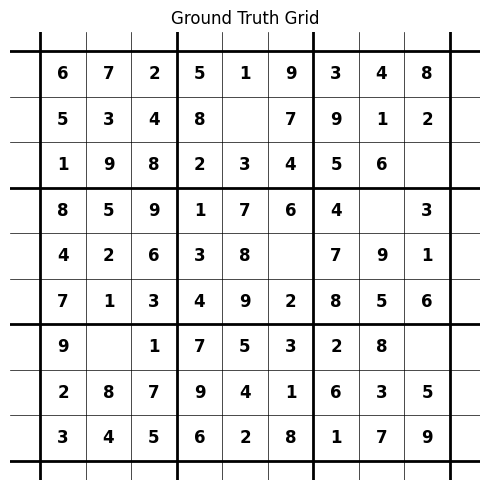

In [5]:
# Try to use an image from our dataset first
from src.data_processor import SudokuDataset

# Check if we have a dataset available
dataset_name = 'mini_sudoku_dataset'  # Change to your dataset name
dataset = SudokuDataset()
test_image_path = None

if os.path.exists(os.path.join(paths['data_dir'], f'{dataset_name}.zip')):
    # Load the dataset
    success = dataset.load_dataset(dataset_name)
    if success:
        # Load a single sample
        samples = dataset.load_samples(max_samples=1)
        if samples:
            # Save the first sample image to a temporary file
            test_image_path = os.path.join(paths['data_dir'], 'temp_test_image.jpg')
            cv2.imwrite(test_image_path, cv2.cvtColor(samples[0]['image'], cv2.COLOR_RGB2BGR))
            print(f"Using test image from dataset: {test_image_path}")
            
            # Also save the ground truth info for comparison
            test_ground_truth = {
                'grid': samples[0]['grid'],
                'solution': samples[0]['solution'],
                'handwritten_mask': samples[0]['handwritten_mask'],
                'mode': samples[0]['mode']
            }
            print(f"Ground truth mode: {test_ground_truth['mode']}")
            
            # Display the ground truth grid
            plot_grid(test_ground_truth['grid'], title="Ground Truth Grid")
        
# If we don't have a dataset or failed to load it, check for the custom test image
if test_image_path is None or not os.path.exists(test_image_path):
    custom_path = os.path.join(paths['data_dir'], 'custom_test_image.png')
    if os.path.exists(custom_path):
        test_image_path = custom_path
        print(f"Using custom test image: {test_image_path}")
        test_ground_truth = None
    else:
        # As a last resort, look for any image files in the data directory
        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
        for file in os.listdir(paths['data_dir']):
            if any(file.lower().endswith(ext) for ext in image_extensions):
                test_image_path = os.path.join(paths['data_dir'], file)
                print(f"Using image found in data directory: {test_image_path}")
                test_ground_truth = None
                break
        else:
            print("No test images found. Please provide a path to a Sudoku image.")

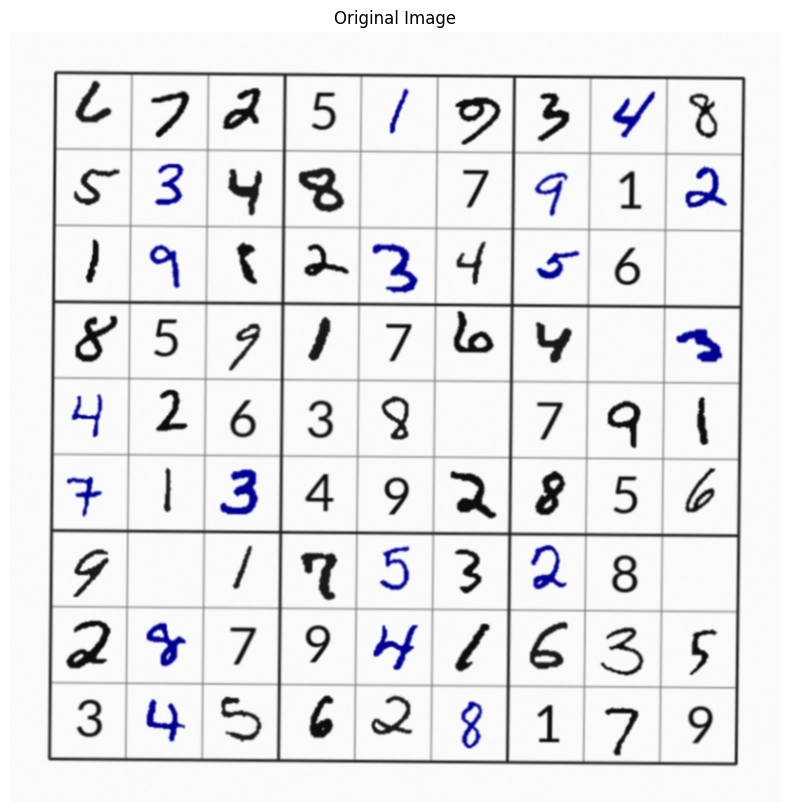

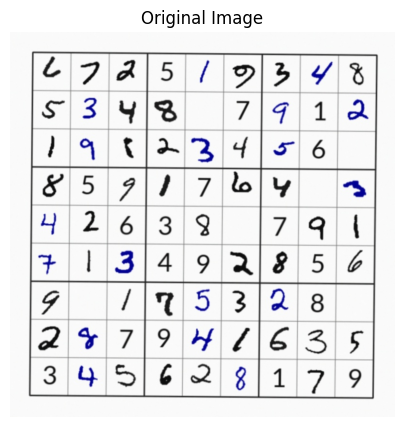

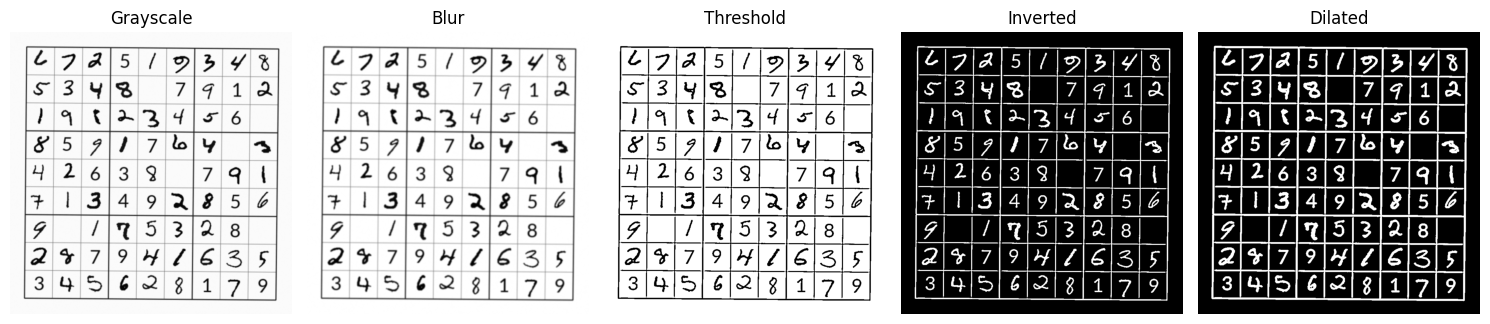

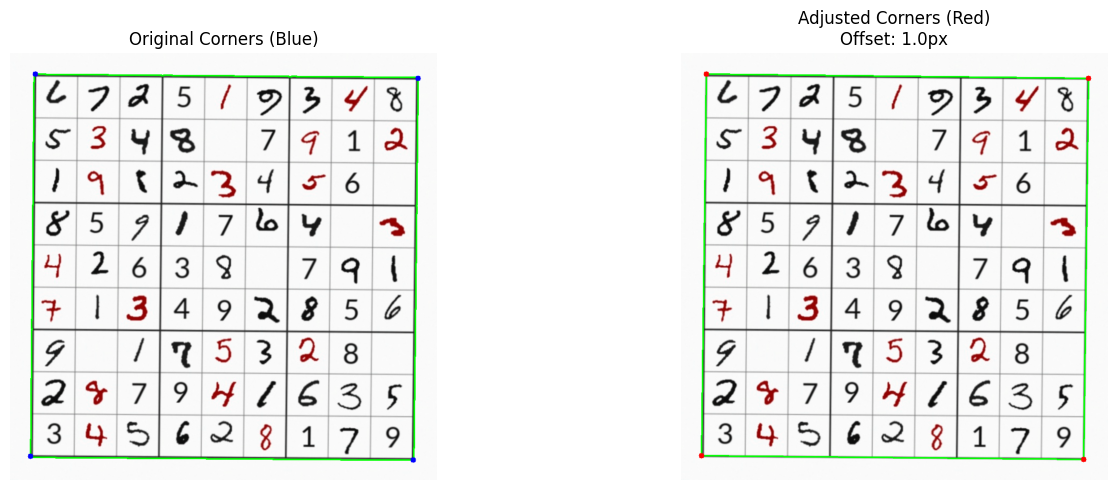

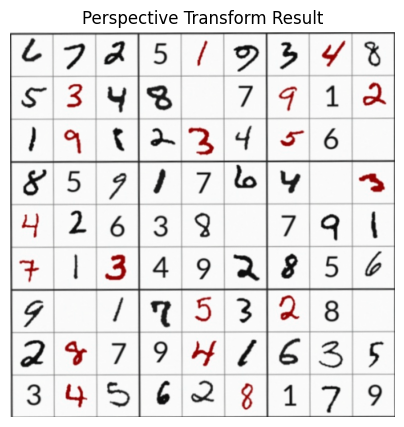

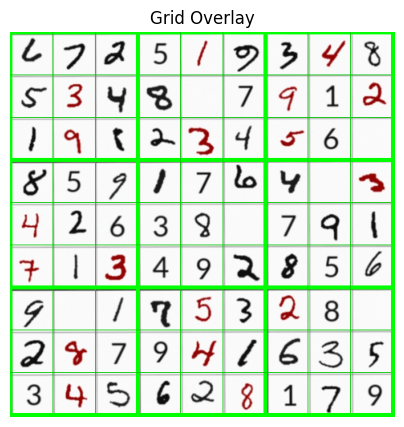

2025-05-14 15:57:02.190311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-14 15:57:02.977214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


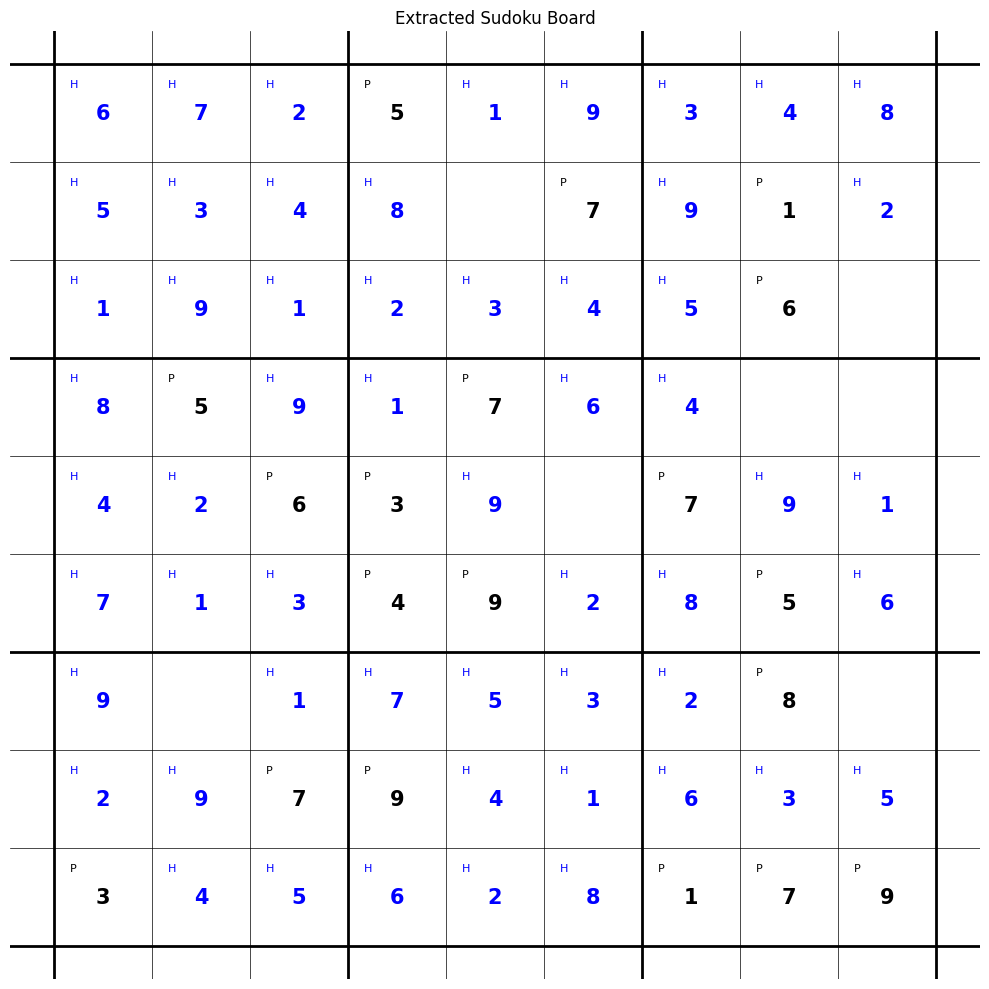

Board Statistics:
- total_cells: 81
- filled_cells: 74
- empty_cells: 7
- handwritten_cells: 55
- printed_cells: 19
- fill_percentage: 91.36%
- is_valid: False
- mode: mixed
- average_confidence: 99.51%

Extracted Grid:
┌───────┬───────┬───────┐
│ 6 7 2 │ 5 1 9 │ 3 4 8 │
│ 5 3 4 │ 8 . 7 │ 9 1 2 │
│ 1 9 1 │ 2 3 4 │ 5 6 . │
├───────┼───────┼───────┤
│ 8 5 9 │ 1 7 6 │ 4 . . │
│ 4 2 6 │ 3 9 . │ 7 9 1 │
│ 7 1 3 │ 4 9 2 │ 8 5 6 │
├───────┼───────┼───────┤
│ 9 . 1 │ 7 5 3 │ 2 8 . │
│ 2 9 7 │ 9 4 1 │ 6 3 5 │
│ 3 4 5 │ 6 2 8 │ 1 7 9 │
└───────┴───────┴───────┘

Accuracy compared to ground truth: 95.06% (77/81 cells correct)
Digit recognition accuracy: 94.67% (71/75 digits correct)
Cell type recognition accuracy: 97.33% (73/75 cell types correct)


In [6]:
# Process the test image
if test_image_path and os.path.exists(test_image_path):
    # Process the image
    board = processor.process_image(test_image_path, display_steps=True)
    
    if board:
        # Display the extracted board
        board.display(title="Extracted Sudoku Board", show_cell_types=True)
        
        # Print board stats
        print("Board Statistics:")
        stats = board.get_stats()
        for key, value in stats.items():
            print(f"- {key}: {value}")
            
        # Print the grid in text format
        print("\nExtracted Grid:")
        board.print_grid()
        
        # Compare with ground truth if available
        if test_ground_truth:
            # Calculate accuracy
            correct_cells = np.sum(board.grid == test_ground_truth['grid'])
            total_cells = 81
            accuracy = correct_cells / total_cells
            print(f"\nAccuracy compared to ground truth: {accuracy:.2%} ({correct_cells}/{total_cells} cells correct)")
            
            # Calculate digit recognition accuracy (ignoring empty cells)
            non_empty_mask = test_ground_truth['grid'] > 0
            correct_digits = np.sum((board.grid == test_ground_truth['grid']) & non_empty_mask)
            total_digits = np.sum(non_empty_mask)
            digit_accuracy = correct_digits / total_digits if total_digits > 0 else 0
            print(f"Digit recognition accuracy: {digit_accuracy:.2%} ({correct_digits}/{total_digits} digits correct)")
            
            # Calculate cell type recognition accuracy
            handwritten_correct = np.sum((board.handwritten_mask == test_ground_truth['handwritten_mask']) & non_empty_mask)
            cell_type_accuracy = handwritten_correct / total_digits if total_digits > 0 else 0
            print(f"Cell type recognition accuracy: {cell_type_accuracy:.2%} ({handwritten_correct}/{total_digits} cell types correct)")
    else:
        print("Failed to process the image.")
else:
    print("No valid test image available.")

## Solve the Sudoku Puzzle

Now that we have a digital representation of the board, let's validate and solve it.

In [7]:
# Validate the board
if board:
    is_valid = board.validate()
    print(f"Board validation: {'Valid' if is_valid else 'Invalid'}")
    
    if is_valid:
        # Solve the board
        print("Solving the puzzle...")
        solution_found = processor.solve_board(board)
        
        if solution_found:
            print("Solution found!")
            # Display the solution
            plot_grid(board.solution, title="Solved Puzzle")
            
            # Compare with ground truth solution if available
            if test_ground_truth and 'solution' in test_ground_truth:
                # Calculate solution accuracy
                solution_correct = np.sum(board.solution == test_ground_truth['solution'])
                solution_accuracy = solution_correct / 81
                print(f"Solution accuracy: {solution_accuracy:.2%} ({solution_correct}/81 cells correct)")
        else:
            print("No solution found. The puzzle may be invalid or too complex.")
    else:
        print("Cannot solve an invalid board. Please check the extracted digits.")

Board validation: Invalid
Cannot solve an invalid board. Please check the extracted digits.


## Process Your Own Image

You can also process your own Sudoku image.

In [8]:
def process_custom_image(image_path):
    """Process a custom Sudoku image."""
    # Check if the file exists
    if not os.path.exists(image_path):
        print(f"File not found: {image_path}")
        return
        
    # Process the image
    board = processor.process_image(image_path, display_steps=True)
    
    if board:
        # Display the extracted board
        board.display(title="Extracted Custom Sudoku Board", show_cell_types=True)
        
        # Print board stats
        print("Board Statistics:")
        stats = board.get_stats()
        for key, value in stats.items():
            print(f"- {key}: {value}")
            
        # Print the grid in text format
        print("\nExtracted Grid:")
        board.print_grid()
        
        # Validate and solve
        is_valid = board.validate()
        print(f"\nBoard validation: {'Valid' if is_valid else 'Invalid'}")
        
        if is_valid:
            # Solve the board
            print("Solving the puzzle...")
            solution_found = processor.solve_board(board)
            
            if solution_found:
                print("Solution found!")
                # Display the solution
                plot_grid(board.solution, title="Solved Custom Puzzle")
            else:
                print("No solution found. The puzzle may be invalid or too complex.")
        else:
            print("Cannot solve an invalid board. Please check the extracted digits.")
    else:
        print("Failed to process the image.")
        
    return board

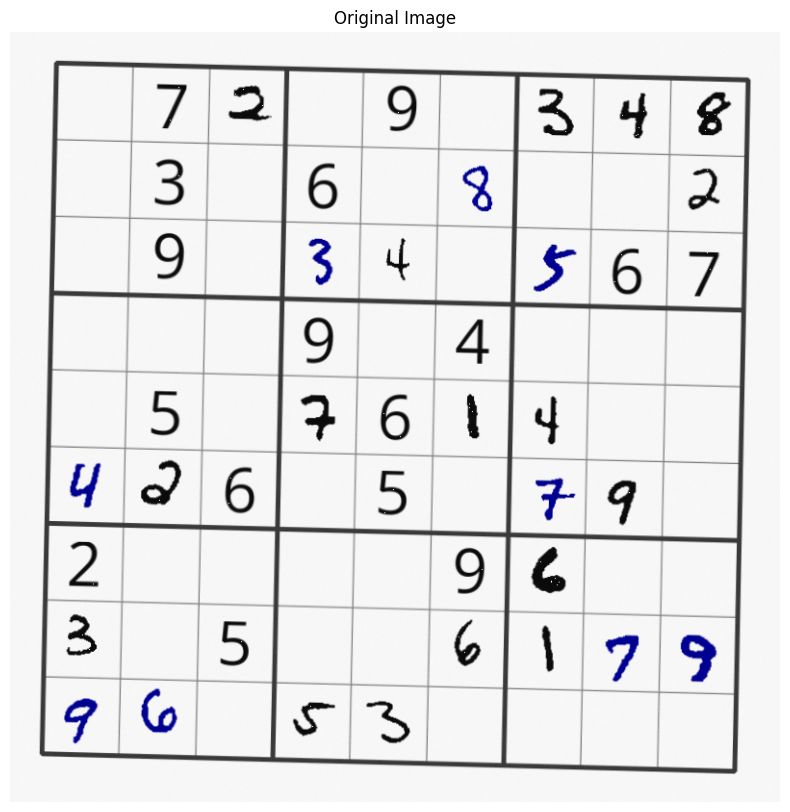

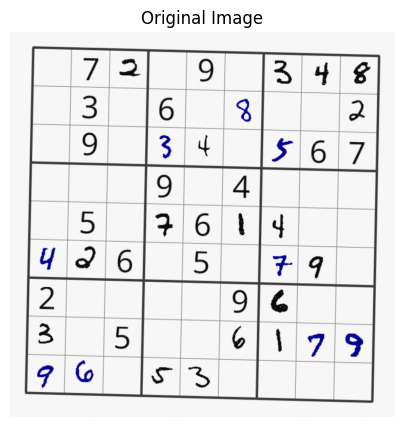

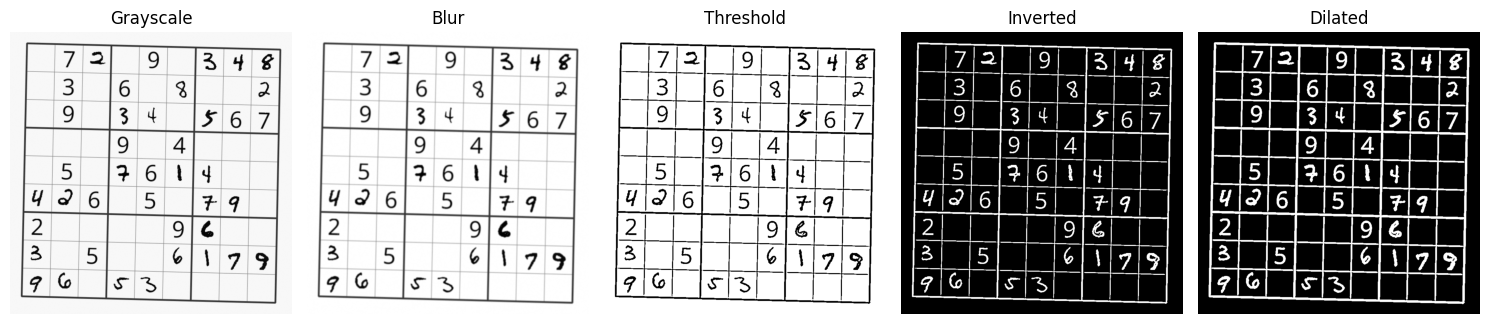

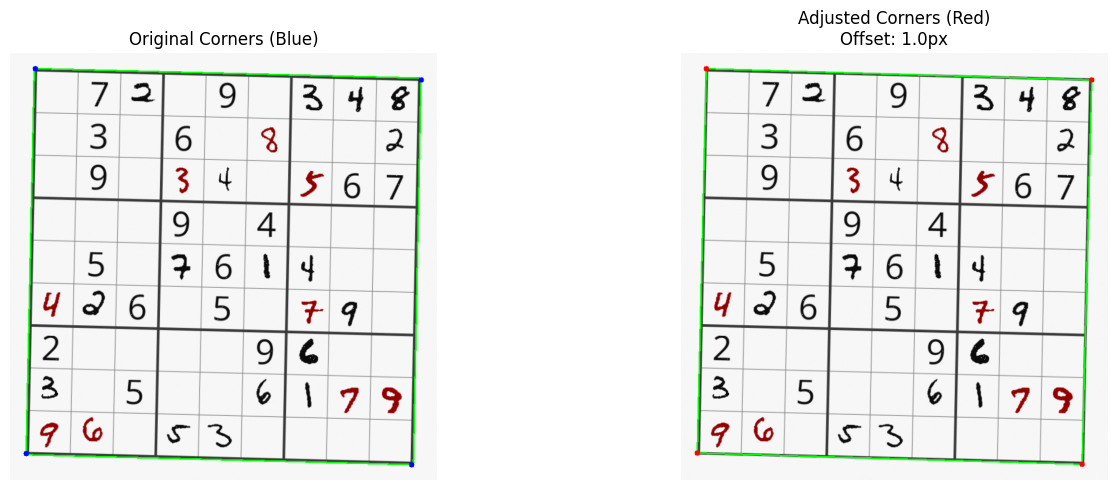

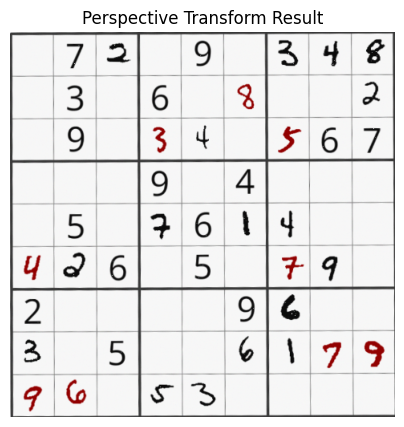

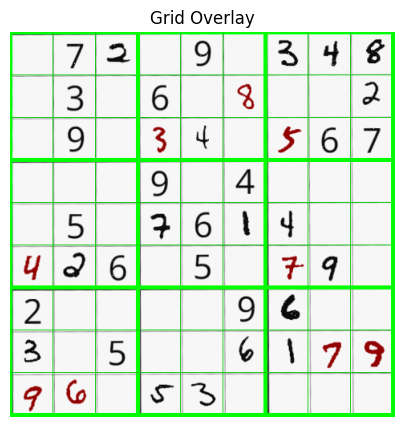

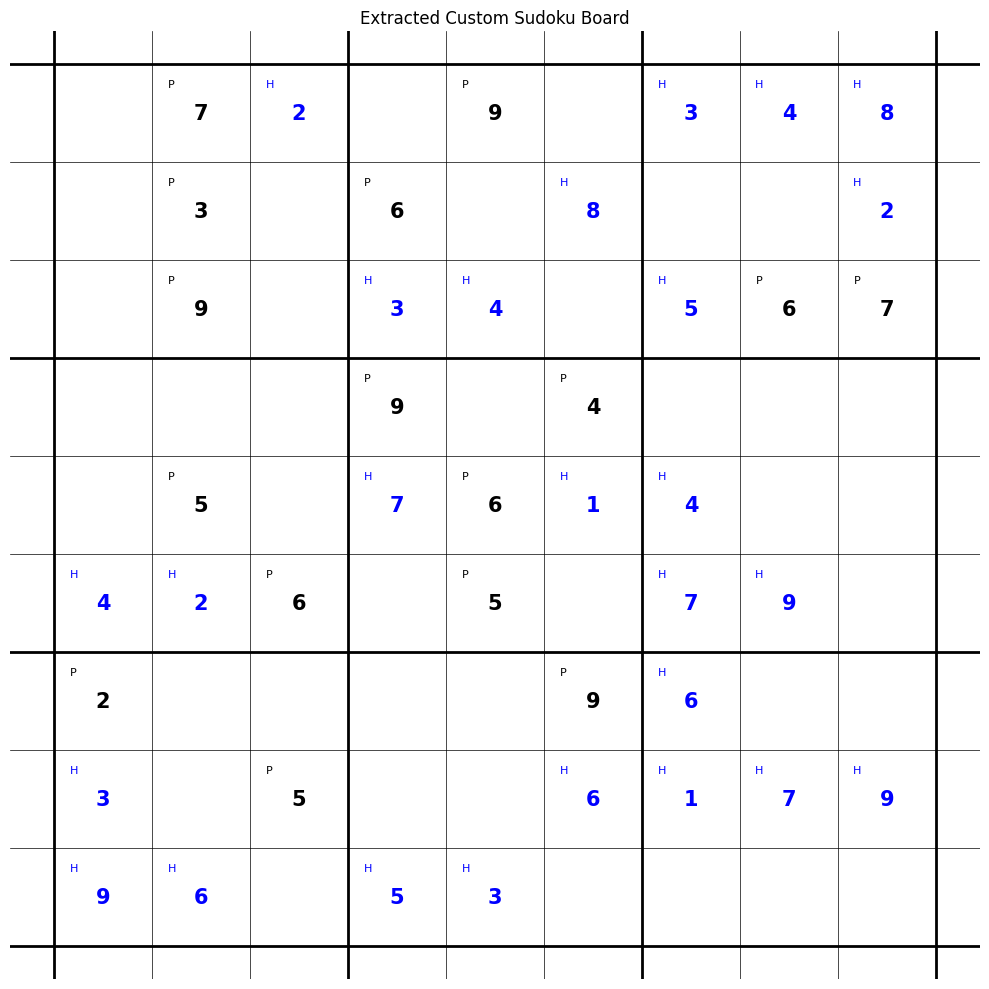

Board Statistics:
- total_cells: 81
- filled_cells: 42
- empty_cells: 39
- handwritten_cells: 26
- printed_cells: 16
- fill_percentage: 51.85%
- is_valid: True
- mode: mixed
- average_confidence: 99.54%

Extracted Grid:
┌───────┬───────┬───────┐
│ . 7 2 │ . 9 . │ 3 4 8 │
│ . 3 . │ 6 . 8 │ . . 2 │
│ . 9 . │ 3 4 . │ 5 6 7 │
├───────┼───────┼───────┤
│ . . . │ 9 . 4 │ . . . │
│ . 5 . │ 7 6 1 │ 4 . . │
│ 4 2 6 │ . 5 . │ 7 9 . │
├───────┼───────┼───────┤
│ 2 . . │ . . 9 │ 6 . . │
│ 3 . 5 │ . . 6 │ 1 7 9 │
│ 9 6 . │ 5 3 . │ . . . │
└───────┴───────┴───────┘

Board validation: Valid
Solving the puzzle...
Solution found!


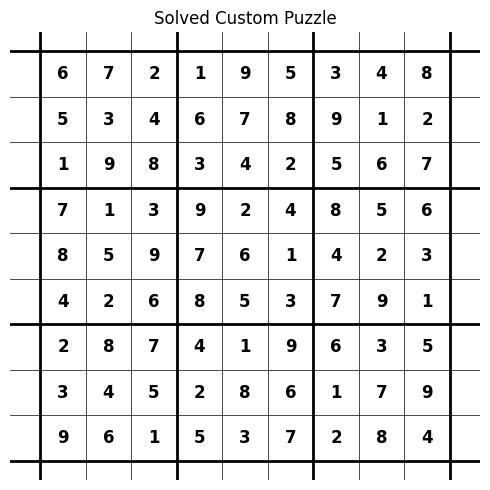

In [15]:
# Example usage with a custom image
# Replace with your own image path
custom_image_path = "../data/M2_test.jpg"
custom_board = process_custom_image(custom_image_path)

## Create and Process a Synthetic Image

Let's generate a synthetic Sudoku image with known ground truth and process it.

In [ ]:
# Import the generator module
from random import sample
from src.generator import SudokuGeneratorConfig, SudokuImageGenerator, SudokuPuzzleGenerator

# Create a custom configuration
config = SudokuGeneratorConfig(
    digit_config={
        "vertical_alignment_offset": 5  # Fix for vertical alignment
    }
)

# Create generator
puzzle_generator = SudokuPuzzleGenerator(config)
image_generator = SudokuImageGenerator(config)

# Generate a puzzle with the PuzzleGenerator
grid, solution = puzzle_generator.generate(mask_rate=0.5)

# Display the grid
print("Generated synthetic Sudoku puzzle:")
plot_grid(grid, title="Synthetic Sudoku Puzzle")

# Generate a mixed mode image
# Calculate handwritten positions for mixed mode
non_empty_positions = [(i, j) for i in range(9) for j in range(9) if grid[i, j] != 0]
handwritten_count = len(non_empty_positions) // 2  # Make half of the filled cells handwritten
handwritten_positions = set(sample(non_empty_positions, handwritten_count))

# Generate the image with mixed mode
synthetic_image, info = image_generator.generate_image(
    grid=grid,
    mode="mixed",
    difficulty="medium",
    background_style="unified",
    handwritten_positions=handwritten_positions
)

# Display the synthetic image
plt.figure(figsize=(10, 10))
plt.imshow(synthetic_image)
plt.title("Synthetic Sudoku Image (Mixed Mode)")
plt.axis('off')
plt.show()

# Save the synthetic image
synthetic_path = os.path.join(paths['data_dir'], 'synthetic_test.png')
cv2.imwrite(synthetic_path, cv2.cvtColor(synthetic_image, cv2.COLOR_RGB2BGR))

In [ ]:
# Process the synthetic image
synthetic_board = processor.process_image(synthetic_path, display_steps=True)

if synthetic_board:
    # Display the extracted board
    synthetic_board.display(title="Extracted Synthetic Board", show_cell_types=True)
    
    # Print board stats
    print("Board Statistics:")
    stats = synthetic_board.get_stats()
    for key, value in stats.items():
        print(f"- {key}: {value}")
        
    # Compare with ground truth
    correct_cells = np.sum(synthetic_board.grid == grid)
    total_cells = 81
    accuracy = correct_cells / total_cells
    print(f"\nAccuracy compared to ground truth: {accuracy:.2%} ({correct_cells}/{total_cells} cells correct)")
    
    # Calculate digit recognition accuracy (ignoring empty cells)
    non_empty_mask = grid > 0
    correct_digits = np.sum((synthetic_board.grid == grid) & non_empty_mask)
    total_digits = np.sum(non_empty_mask)
    digit_accuracy = correct_digits / total_digits if total_digits > 0 else 0
    print(f"Digit recognition accuracy: {digit_accuracy:.2%} ({correct_digits}/{total_digits} digits correct)")
    
    # Calculate cell type recognition accuracy
    synthetic_handwritten_mask = np.zeros((9, 9), dtype=int)
    for pos in handwritten_positions:
        synthetic_handwritten_mask[pos[0], pos[1]] = 1
        
    handwritten_correct = np.sum((synthetic_board.handwritten_mask == synthetic_handwritten_mask) & non_empty_mask)
    cell_type_accuracy = handwritten_correct / total_digits if total_digits > 0 else 0
    print(f"Cell type recognition accuracy: {cell_type_accuracy:.2%} ({handwritten_correct}/{total_digits} cell types correct)")
    
    # Validate and solve
    is_valid = synthetic_board.validate()
    print(f"\nBoard validation: {'Valid' if is_valid else 'Invalid'}")
    
    if is_valid:
        # Solve the board
        print("Solving the puzzle...")
        solution_found = processor.solve_board(synthetic_board)
        
        if solution_found:
            print("Solution found!")
            # Display the solution
            plot_grid(synthetic_board.solution, title="Solved Synthetic Puzzle")
            
            # Compare with ground truth solution
            solution_correct = np.sum(synthetic_board.solution == solution)
            solution_accuracy = solution_correct / 81
            print(f"Solution accuracy: {solution_accuracy:.2%} ({solution_correct}/81 cells correct)")
        else:
            print("No solution found. The puzzle may be invalid or too complex.")
    else:
        print("Cannot solve an invalid board. Please check the extracted digits.")
else:
    print("Failed to process the synthetic image.")

## Conclusion

In this notebook, we've demonstrated the complete Sudoku AI pipeline:

1. Loading trained models for digit recognition and cell type classification
2. Processing Sudoku images to extract the board
3. Recognizing digits and cell types
4. Validating the extracted board
5. Solving the Sudoku puzzle
6. Evaluating the system on both real and synthetic images

This complete pipeline can be used to solve Sudoku puzzles from images, whether they are from books, newspapers, or digital sources.